In [104]:
# Importation des bibliothèques
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


from pathlib import Path
from sklearn.impute import SimpleImputer
from sklearn.metrics import mean_absolute_error, mean_squared_error, root_mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from scipy.stats import randint
import os



# Importation de la configuration
from config.config import TEST_RATIO, SEED

# Importation des fonctions nécessaires
from src.data_processing.load_data import load_data
from src.data_science.data import *
from src.figures.figures_plot import *
from src.data_science.models import *


# Introduction

L'objectif de ce projet est de développer un modèle capable de prédire le prix des maisons en appliquant des techniques de data science et de machine learning. La problématique consiste à analyser comment différentes caractéristiques d’un bien immobilier, comme la superficie, le nombre de chambres, ou encore l’emplacement, influencent son prix. Ce projet me permettra de renforcer mes compétences en manipulation de données, analyse exploratoire et construction de modèles prédictifs.

Pour ce faire, nous allons travailler avec un jeu de données étiquetées, dans lequel chaque maison est associée à un prix connu. Afin de mener à bien ce travail, nous commencerons par une analyse exploratoire des données (EDA) pour comprendre les principales caractéristiques et les relations présentes dans le jeu de données. Ensuite, nous construirons des modèles prédictif en utilisant des techniques de machine learning et une validation croisée pour évaluer les performance.

Nous utiliserons également Git pour faciliter le travail en équipe et permettre un suivi collaboratif des modifications, assurant une gestion efficace des versions du code et des données. L'objectif final est de créer un modèle capable de prédire avec précision le prix de nouvelles maisons en se basant sur les caractéristiques disponibles, tout en nous offrant une expérience pratique des méthodes de machine learning et de gestion de projet en équipe.

# 1-EDA

## Préparation des Données

Dans cette section, nous allons préparer les données pour l'analyse et la modélisation. Cela inclut la gestion des valeurs manquantes, la correction des incohérences dans les données, et la transformation des variables si nécessaire.


## Importation des données

In [105]:
# Définir la racine du projet
BASE_DIR = os.path.dirname(os.path.abspath("__file__"))

# Chemin relatif vers les données
data_file = os.path.join(BASE_DIR, "data", "raw", "house_prices.csv")

# Charger les données avec la fonction load_data
data = load_data(data_file)

In [106]:
# Apperçu des données
data.head()

,price,AreA,bedrooms,BATHROOMS,stories,mainroad,guestroom,basement,hotwaterheating,air conditioning,parking,prefarea,furnishing STATUS,houSeaGe
0,4543000.0,4990.0,4.0,2.0,2.0,yes,yes,yes,no,no,0.0,yes,furnished,15.0
1,8080940.0,7000.0,3.0,2.0,4.0,yes,no,no,no,yes,2.0,no,FURNISHED,11.0
2,8750000.0,4321.0,3.0,2.0,2.0,yes,no,yes,yes,no,2.0,no,FURNISHED,NaN
3,1890000.0,1700.0,3.0,1.0,2.0,yes,no,no,no,no,0.0,no,unfurnished,NaN
4,12215000.0,7500.0,4.0,2.0,2.0,yes,no,yes,no,yes,3.0,yes,furnished,NaN


### Statistiques descriptives

Nous allons dans un premier temps faire une analyse rapide de notre base de données.


In [107]:
# Types des colonnes
print("Types des colonnes:")
print(data.dtypes)

# Statistiques descriptives
print("\nStatistiques descriptives:")
print(data.describe())


Types des colonnes:
price                float64
AreA                 float64
bedrooms             float64
BATHROOMS            float64
stories              float64
mainroad              object
guestroom             object
basement              object
hotwaterheating       object
air conditioning      object
parking              float64
prefarea              object
furnishing STATUS     object
houSeaGe             float64
dtype: object

Statistiques descriptives:
              price          AreA    bedrooms   BATHROOMS     stories  \
count  7.890000e+02    794.000000  785.000000  788.000000  794.000000   
mean   5.406437e+06   5482.997481    3.048408    1.469543    1.935768   
std    2.217827e+06   2203.340686    0.742445    0.669037    0.951354   
min    1.750000e+06   1650.000000    1.000000    1.000000    1.000000   
25%    3.640000e+06   3665.000000    3.000000    1.000000    1.000000   
50%    4.893000e+06   5310.000000    3.000000    1.000000    2.000000   
75%    7.210000e+06  

D'après les résultats ci-dessus, on voit que nos variables sont de types object et float. Certains ne sont pas dans le bon type, nous allons les corriger par la suite.

#### Renommage des colonnes

Le renommage des colonnes est une étape clé pour rendre les noms des variables plus clairs et compréhensibles. Cela facilite l’analyse, améliore la lisibilité et garantit la cohérence du jeu de données.

In [108]:
# Renommer les colonnes en français avec la fonction rename_columns du fichier data.py
data = rename_columns(data)

#### Valeurs manquantes

Gérer les valeurs manquantes est essentiel pour assurer la qualité des données et éviter les biais dans les analyses. Cette étape vise à identifier et traiter ces absences de manière appropriée.

In [109]:
# Vérification des valeurs nulles
print("\nValeurs nulles par colonne:")
data.isnull().mean() * 100


Valeurs nulles par colonne:


prix                           2.472188
superficie                     1.854141
chambres                       2.966625
salles_de_bain                 2.595797
etages                         1.854141
proximite_route_principale     1.977750
chambre_amis                   2.843016
sous_sol                       2.719407
chauffage_eau_chaude           2.224969
climatisation                  1.854141
places_parking                 1.977750
zone_preferee                  1.730532
statut_meublement              2.843016
age_maison                    99.381953
dtype: float64

D'après le code ci-dessus, 99 % des valeurs de la variable `age_maison` sont manquantes. Nous avons donc décidé de la supprimer.

In [110]:
# Suppression de la variable age_maison
data.drop('age_maison', axis=1, inplace=True)

La variable `prix` possède 2 % de valeurs manquantes, ce qui est peu significatif. Nous pouvons donc supprimer les quelques lignes où le prix est manquant.


In [111]:
print(data['prix'].isnull().mean() * 100)

2.4721878862793574


In [112]:
# Suppression des lignes dont la variable prix est manquante
data.dropna(subset=['prix'], inplace=True)

In [113]:
# Modalités de la variable statut_meublement
data['statut_meublement'].value_counts()

statut_meublement
semi-furnished    308
unfurnished       234
furnished         220
Furnished           4
FURNISHED           3
Name: count, dtype: int64

##### Corrections des valeurs inchohérentes:

La variable statut_meublement présente une incohérence dans les valeurs. Certaines valeurs (modalités)  sont en majiscule et d'autre sont en miniscule. Nous allons donc uniformiser les valeurs en miniscule.

In [114]:
# Correction de la variable statut_meublement
data['statut_meublement'] = data['statut_meublement'].str.lower()

##### Imputation des valeurs manquantes:

Nous avons observé précédemment que certaines de nos variables contiennent des valeurs manquantes représentant entre 1 % et 2 % des données. Nous allons donc procéder à leur imputation, car les supprimer pourrait entraîner une perte significative d'informations.

In [115]:
# Colonnes à imputer
colonnes_impute = [
    'statut_meublement',
    'proximite_route_principale',
    'chambre_amis',
    'sous_sol',
    'chauffage_eau_chaude',
    'climatisation',
    'zone_preferee',
    'salles_de_bain',
    'chambres',
    'etages',
    'places_parking'
]

# Imputation des valeurs manquantes avec la fonction impute_mode_function du fichier data.py
impute_mode_function(data, colonnes_impute)

In [116]:
# Convertiion de certaines variables en catégories avec la fonction convert_to_int du fichier data.py
variables_categorielles = [
    'salles_de_bain',
    'chambres',
    'etages',
    'places_parking'
]
convert_to_int(data, variables_categorielles)

In [117]:
# Imputaion des variables numériques par moyenne

imputer = SimpleImputer(strategy='mean')
data[['superficie']] = imputer.fit_transform(data[['superficie']])

#sauvgarde des données nettoyées et prétraitées
data_cleaned_path = os.path.join(BASE_DIR, "data", "primary", "house_prices_cleaned.csv")
data.to_csv(data_cleaned_path, index=False)

## Visualisation des données:

Dans cette partie, nous allons procéder à la visualisation des données afin d'examiner la distribution de nos variables une par une. Nous effectuerons également une analyse bivariée pour déterminer s'il est possible de détecter une tendance entre la variable prix et les autres variables.

#### Analyse univariée:
Une étape indispensable dans l'analyse de données est l'analyse univariée, qui consiste à étudier une seule variable à la fois pour en comprendre la distribution, les caractéristiques principales, et identifier d'éventuelles anomalies.
##### Variables continues:

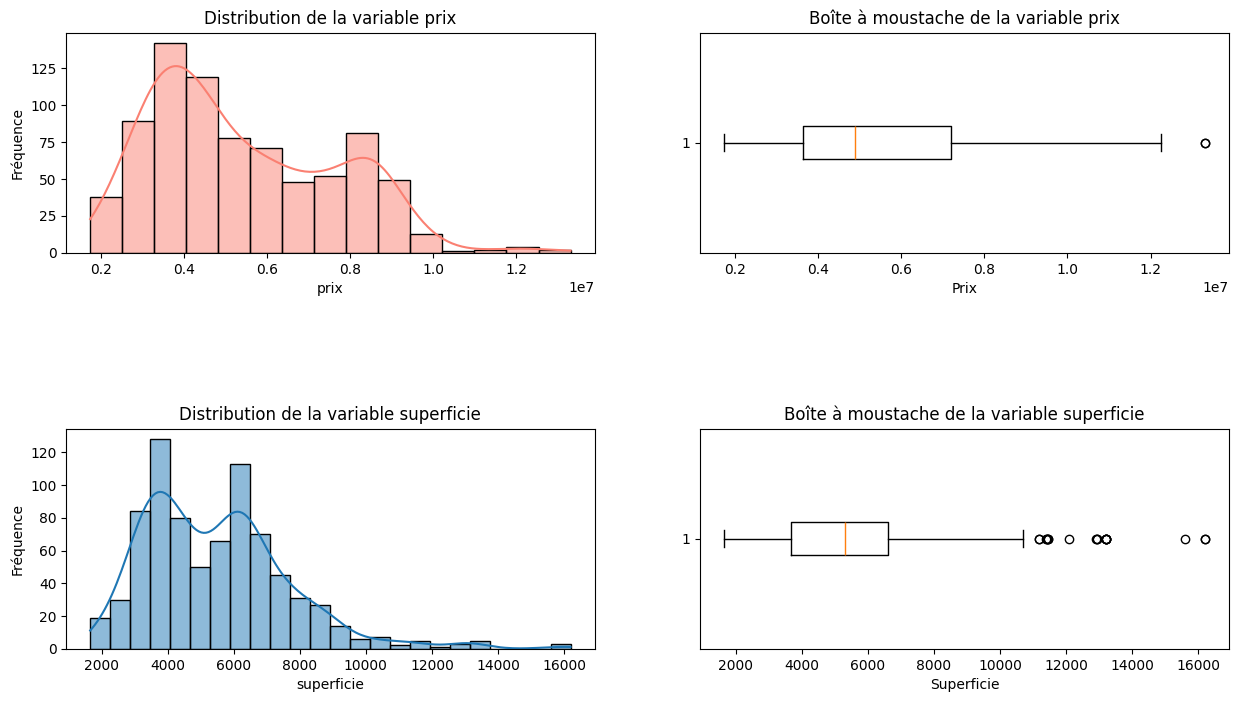

In [118]:
# Visualisation des distributions du prix et de la superficie avec la fonction plot_distributions du fichier figures_plot.py
plot_distributions(data)

L'histogramme et le boxplot de la variable prix révèlent que la plupart des maisons dans le jeu de données se vendent à des prix compris entre 3 millions et 4 millions, ainsi qu'entre 5 millions et 6 millions. On remarque également des valeurs aberrantes à 12 millions, qui correspondent probablement à des maisons particulières.

L'histogramme et le boxplot de la variable superficie illustrent que la distribution est asymétrique. Le boxplot est décalé vers la gauche, la plupart des valeurs se situant approximativement entre 3 000 et 7 000 pieds carrés. Cela indique que la majorité des maisons possèdent une superficie dans cette plage. Les points au-dessus de la limite supérieure identifient des valeurs atypiques, c’est-à-dire des maisons ayant des superficies exceptionnellement grandes, atteignant parfois plus de 16 000 pieds carrés.

Nous allons traiter les valeurs aberrantes afin d'éviter qu'elles n'influencent négativement les performances des modèles et ne biaisent les résultats des analyses.

In [119]:
# Suppression des valeurs extrêmes avec la fonction remove_outliers du fichier data.py
data = remove_outliers(data,'prix', 0.01) 
data = remove_outliers(data,'superficie', 0.025) 

print(f'Taille des données après correction {data.shape[0]}')

Taille des données après correction 734


##### Visualistaion des variables catégorielles:
L'analyse univariée des variables catégorielles permet d'explorer leur distribution à travers des graphiques simples, comme les diagrammes en barres. Cette section se concentre sur la représentation visuelle des fréquences des différentes catégories pour mieux comprendre leur répartition.

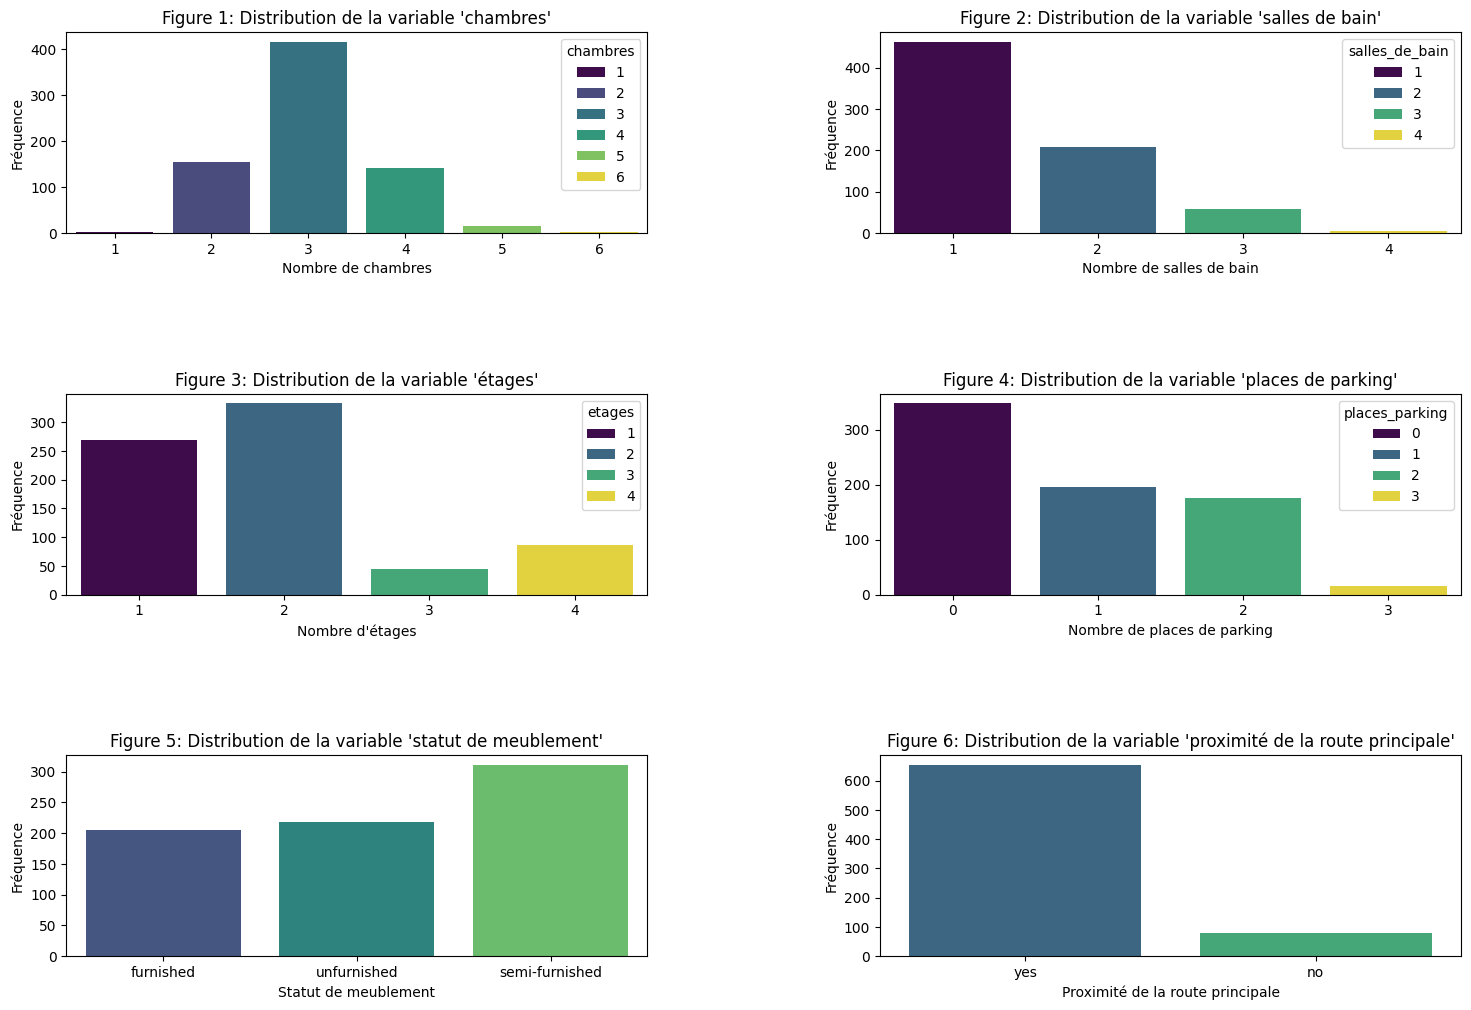

In [120]:
# Affichage des distributions des variables catégorielles avec la fonction plot_categorical_distributions du fichier figures_plot.py
plot_categorical_distributions(data)


Les figures ci-dessus montrent que la plupart des maisons de notre jeu de données sont des maisons à 3 chambres. La plupart d'entre elles ont également une seule salle de bain. La majorité des maisons comptent 1 ou 2 étages. La plupart d'entre elles n'ont pas de places de parking. On observe davantage de maisons à moitié meublées, et il y a autant de maisons meublées que de non meublées. Enfin, la grande majorité des maisons se situent près des routes principales.

#### Analyse bivariée:
L'analyse bivariée est une étape essentielle qui permet d'examiner la relation entre deux variables, qu'elles soient quantitatives ou qualitatives, afin d'identifier d'éventuelles corrélations ou associations.
##### Croisement de la variable Prix et des autres variables :  
Nous allons visualiser le prix en fonction des autres variables afin d'observer les relations potentielles et d'identifier d'éventuelles tendances ou corrélations qui pourraient influencer le prix.

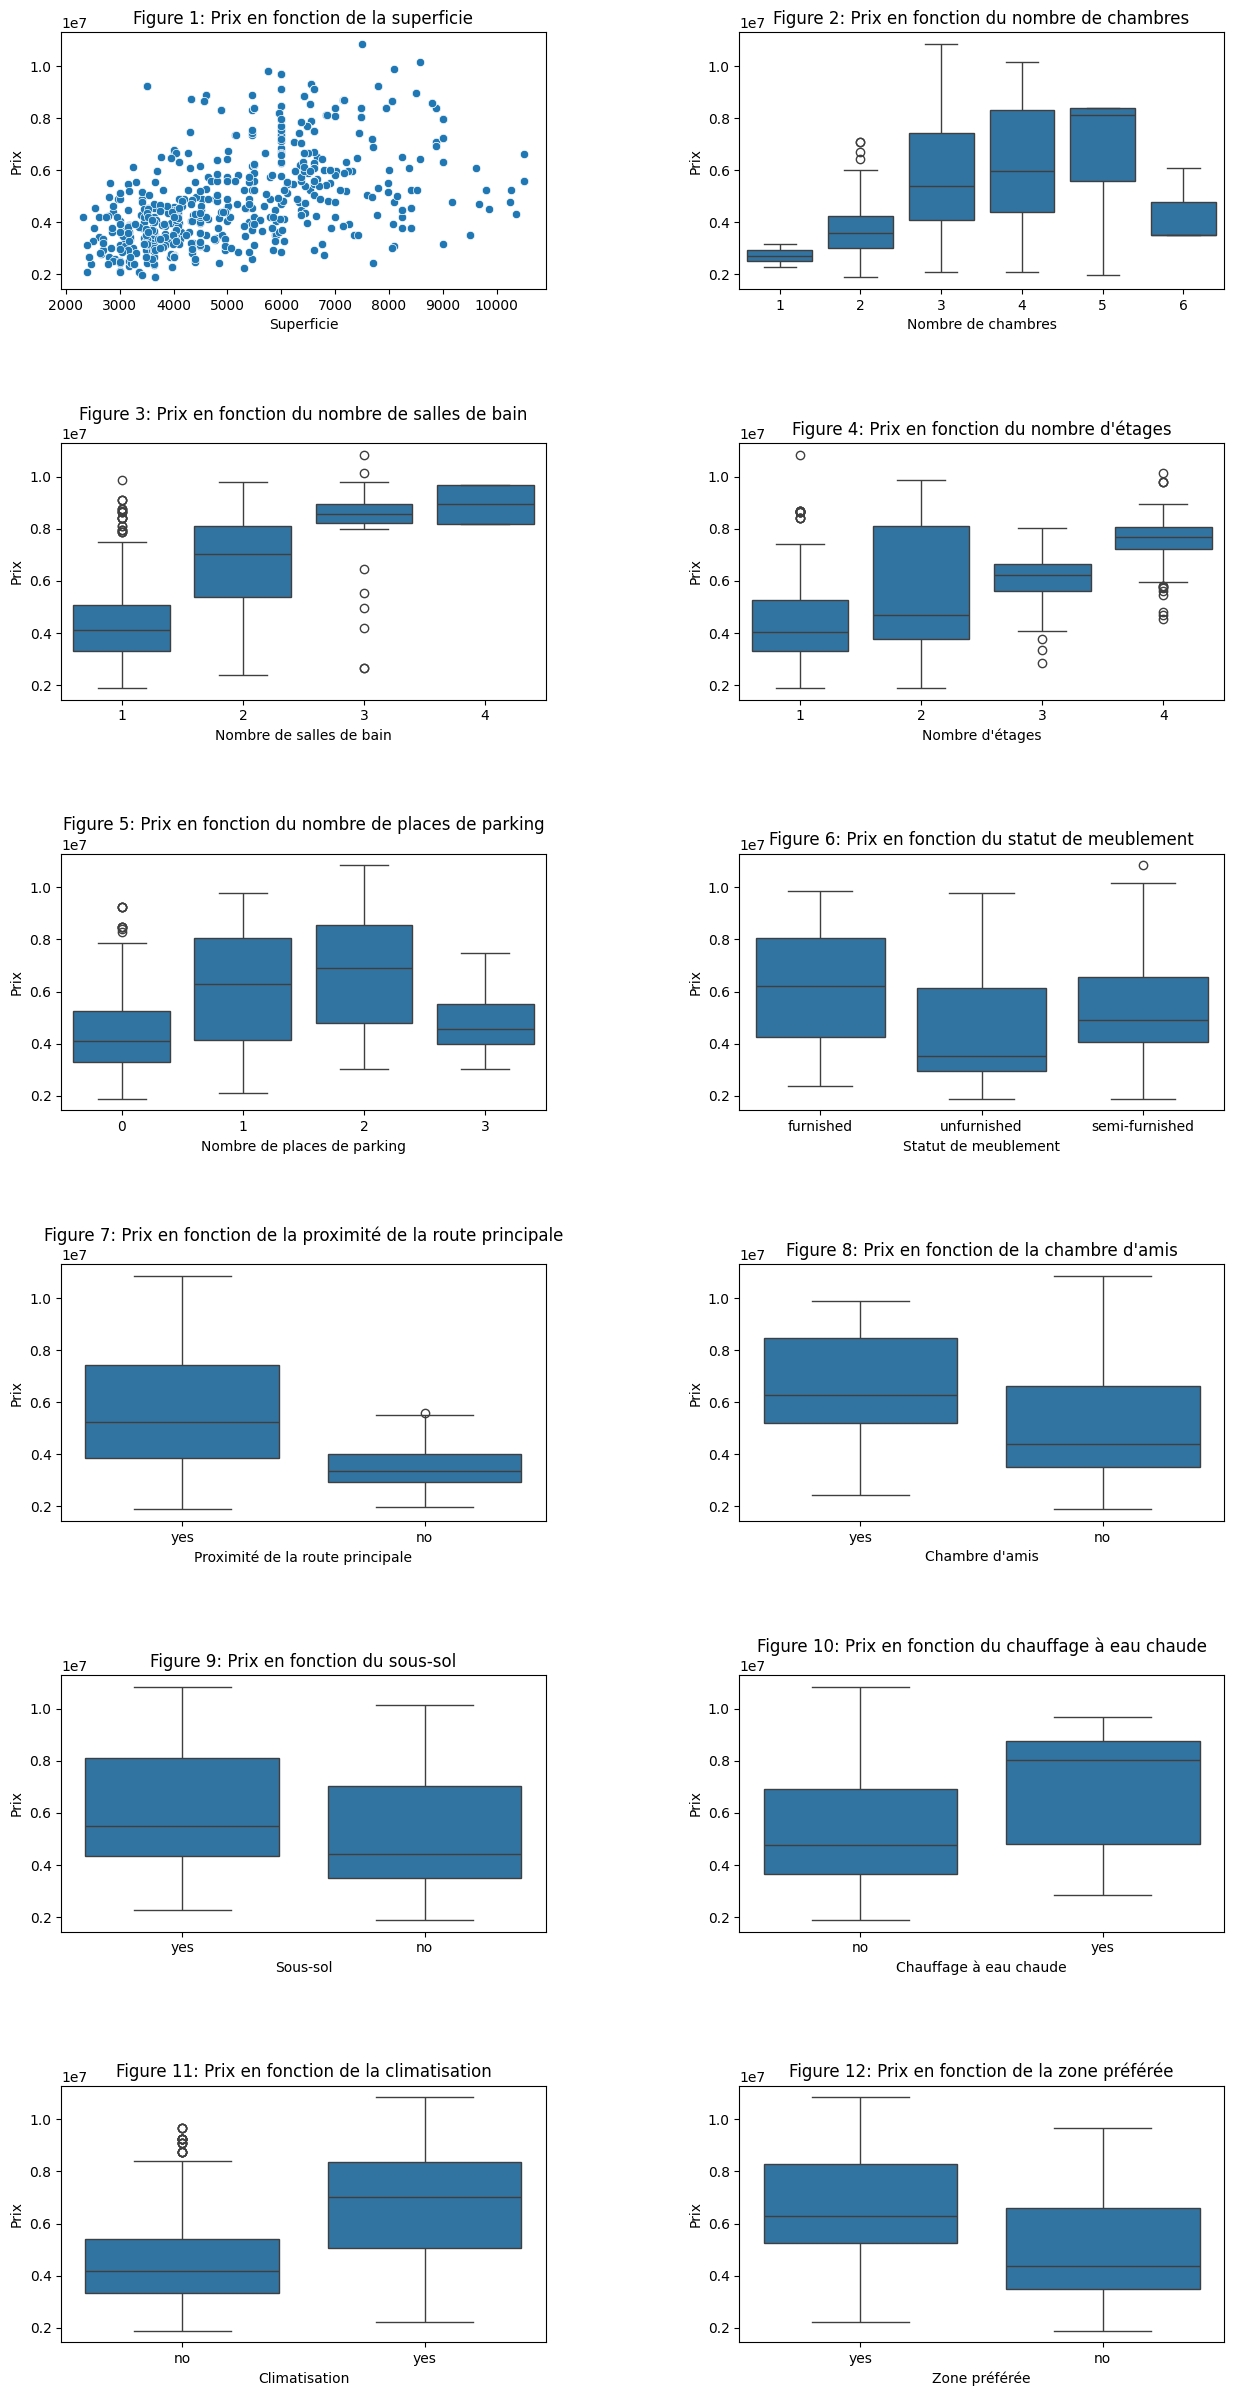

In [121]:
# Affichage des relations entre les variables et le prix avec la fonction plot_price_relationships du fichier figures_plot.py
plot_price_relationships(data)

Sur la figure 1, on peut observer une tendance générale: plus la superficie est grande, plus le prix est élevé. Cependant, il existe une grande dispersion des points de données, ce qui signifie qu'il y a beaucoup de variations dans les prix des propriétés de taille similaire. Il existe également un point de données atypique avec un prix beaucoup plus élevé que les autres propriétés, même si sa superficie est similaire à certaines autres propriétés.

La figure 2 indique que plus une maison a de chambres, plus son prix est élevé en moyenne. On observe cette tendance pour les maisons ayant entre 1 et 5 chambres. Pour les maisons à 6 chambres, les prix sont plus bas. De plus, pour les maisons de 4 ou 5 chambres, la distribution des prix est large avec des valeurs variées, alors que pour celles à 1 ou 2 chambres, les valeurs sont concentrées autour de la moyenne.

Les figures 3 et 4 montrent que plus les maisons ont de salles de bain ou d'étages, plus le prix est élevé.

Dans les figures 5 et 6, on observe une différence de distribution entre les maisons qui ont des places de parking et celles qui n'en ont pas. On remarque également que les maisons meublées ou semi-meublées ont une distribution de prix plus élevée que celles qui ne le sont pas.

Les figures 7, 8, 9, 10, 11 et 12 montrent que les maisons situées à proximité des routes principales, celles qui ont des chambres d'amis, des sous-sols, un chauffage à eau chaude ou de la climatisation, ainsi que celles situées dans des zones préférées, affichent en moyenne des prix élevés.

#### Analyse multivariée:

L'analyse multivariée permet d'étudier les relations complexes entre plusieurs variables simultanément. Cette approche est essentielle pour comprendre les interactions, identifier des patterns cachés et déterminer l'impact relatif des différentes variables sur une variable cible. Dans cette section, nous allons réaliser une Analyse des Correspondances Multiples (ACM) pour explorer et visualiser les associations entre les variables catégorielles et dégager des patterns significatifs.

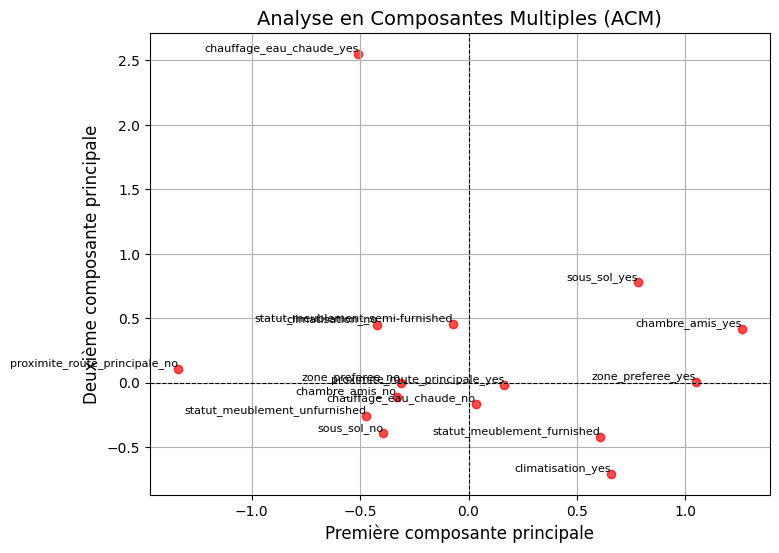

In [122]:
# Extraction du tableau de données de variables catégorielles
data_cat = data[['statut_meublement', 'proximite_route_principale', 
                  'chambre_amis', 'sous_sol', 'chauffage_eau_chaude', 
                  'climatisation', 'zone_preferee']]

# ACM avec la fonction plot_mca du fichier figures_plot.py
plot_mca(data_cat)

L'analyse des correspondances multiples (ACM) montre que l'axe 1 oppose les maisons situées près des routes principales à celles situées dans des zones privilégiées. Cela indique que la localisation joue un rôle important dans les choix des acheteurs.

L'axe 2 distingue les maisons semi-meublées et sans climatisation de celles qui sont meublées et climatisées, suggérant que le confort influe sur les préférences.

De plus, on remarque que les maisons semi-meublées et climatisées partagent des caractéristiques similaires. Enfin, il existe une ressemblance entre les maisons non meublées et celles sans sous-sol.

Il est parfois nécessaire de stocker des tableaux et des données qui serviront à faire du reporting. Dans la cellule ci-dessus, on stocke dans un fichier Excel l'analyse descriptive des variables catégorielles.

In [123]:
# Description des variables catégorielles
data_cat.describe()

# Sauvegarde de la table de description des variables catégorielles sous format Excel
reporting_path = os.path.join(BASE_DIR, "data", "reporting")
data_cat.describe().to_excel(os.path.join(reporting_path, "data_cat_description.xlsx"))


##### Typages des variables:
L'encodage des variables est souvent très utile, surtout lorsqu'on souhaite faire du machine learning et que l'on dispose de variables catégorielles. Dans cette section, nous allons encoder certaines variables pour les rendre exploitables par les algorithmes de machine learning.

In [124]:
# Conversion des variables booléennes "yes" et "no" en entiers, si les colonnes existent
bool_columns = ['proximite_route_principale', 'chambre_amis', 'sous_sol', 'chauffage_eau_chaude', 'climatisation', 'zone_preferee']

# Utilisation de la fonction encode_boolean_columns du fichier data.py pour encoder les variables booléennes
data = encode_boolean_columns(data, bool_columns)

# Encodage de la variable statut_meublement avec la fonction encode_statut_meublement du fichier data.py
encode_statut_meublement(data)

# Affichage des types des colonnes
print(data.info())
data

# Sauvegarde des données traitées et transformées
data_processed_path = os.path.join(BASE_DIR, "data", "intermediary", "house_prices_processed.csv")
data.to_csv(data_processed_path, index=False)

<class 'pandas.core.frame.DataFrame'>
Index: 734 entries, 0 to 808
Data columns (total 13 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   prix                        734 non-null    float64
 1   superficie                  734 non-null    float64
 2   chambres                    734 non-null    int64  
 3   salles_de_bain              734 non-null    int64  
 4   etages                      734 non-null    int64  
 5   proximite_route_principale  734 non-null    int64  
 6   chambre_amis                734 non-null    int64  
 7   sous_sol                    734 non-null    int64  
 8   chauffage_eau_chaude        734 non-null    int64  
 9   climatisation               734 non-null    int64  
 10  places_parking              734 non-null    int64  
 11  zone_preferee               734 non-null    int64  
 12  statut_meublement           734 non-null    int64  
dtypes: float64(2), int64(11)
memory usage: 9

# 2-Validation croisée

La validation croisée est une étape cruciale dans le processus de modélisation en machine learning. Elle permet d'évaluer la performance d'un modèle de manière plus robuste en le testant sur plusieurs sous-ensembles du jeu de données. Cette technique aide à prévenir le surapprentissage (overfitting) et à obtenir une estimation plus fiable de la performance du modèle sur des données non vues.

Pour effectuer une validation croisée, il est nécessaire de diviser le jeu de données en plusieurs parties : un ensemble d'entraînement pour ajuster le modèle et un ensemble de test pour évaluer sa performance. Dans cette section, nous allons diviser notre jeu de données en ensembles d'entraînement et de test.

In [125]:
# Diviser les données en ensembles d'entraînement et de test
X_train, X_test, y_train, y_test = split_data(data, TEST_RATIO, SEED)

# Afficher les dimensions des ensembles
print(f"Train set: {X_train.shape}, {y_train.shape}")
print(f"Test set: {X_test.shape}, {y_test.shape}")

# sauvegarde des données d'entraînement et de test
data_intermediary_path = os.path.join(BASE_DIR, "data", "intermediary")
X_train.to_csv(os.path.join(data_intermediary_path, "X_train.csv"), index=False)
X_test.to_csv(os.path.join(data_intermediary_path, "X_test.csv"), index=False)
y_train.to_csv(os.path.join(data_intermediary_path, "y_train.csv"), index=False)
y_test.to_csv(os.path.join(data_intermediary_path, "y_test.csv"), index=False)

Train set: (587, 12), (587,)
Test set: (147, 12), (147,)


# 3-Machine Learning

### Baseline:

Avant de passer au machine learning, nous allons commencer par établir un modèle simple. C'est un modèle assez basique, mais qui peut nous donner une première idée. Plus précisément, nous allons construire une baseline qui détermine le prix moyen des maisons en fonction du nombre de chambres.

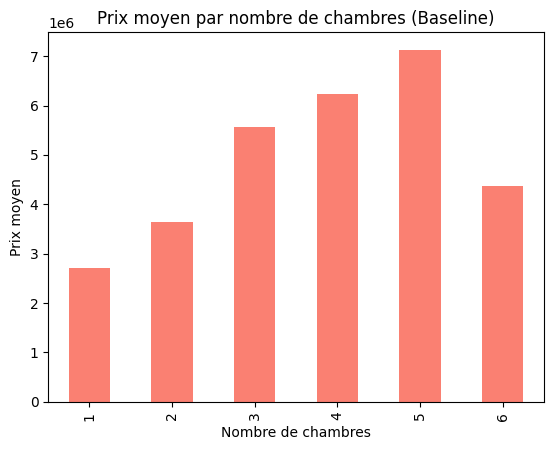

In [126]:
data_train = pd.concat([X_train, y_train], axis=1)

# Calculer le prix moyen par nombre de chambres avec la fonction baseline_model du fichier models.py
baseline = baseline_model(data_train)

# Afficher la baseline sous forme de graphique en barres
baseline.plot(x='chambres', y='prix_moyen', kind='bar', color='salmon')
plt.title('Prix moyen par nombre de chambres (Baseline)')
plt.xlabel('Nombre de chambres')
plt.ylabel('Prix moyen')
plt.show()


Ce graphique illustre le prix moyen en fonction du nombre de chambres. On remarque que le prix moyen est d'autant plus élevé que le nombre de chambres augmente de 1 à 5. Cependant, pour les maisons ayant 6 chambres, le prix moyen est plus bas que celui des maisons ayant 3, 4 ou 5 chambres.

Erreur absolue moyenne (MAE) sur le jeu de test : 1669379.89
Erreur quadratique moyenne (RMSE) sur le jeu de test : 1967262.81


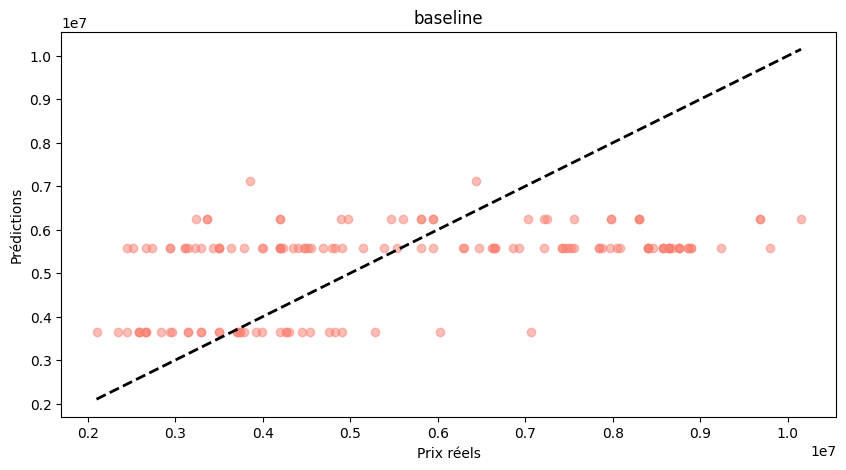

In [127]:
# Pour chaque valeur de chambres dans X_test, on applique le prix moyen correspondant
y_pred_base = X_test.copy()  # On copie X_test pour éviter de modifier l'original
y_pred_base['prix_prediction'] = X_test['chambres'].map(baseline)

# Calculer les métriques de performance
mae = mean_absolute_error(y_test, y_pred_base['prix_prediction'])
rmse = np.sqrt(mean_squared_error(y_test, y_pred_base['prix_prediction']))

print(f"Erreur absolue moyenne (MAE) sur le jeu de test : {mae:.2f}")
print(f"Erreur quadratique moyenne (RMSE) sur le jeu de test : {rmse:.2f}")

# Visualiser les prédictions de la baseline vs les valeurs réelles
plot_predictions_baseline(y_test, y_pred_base['prix_prediction'],'baseline')

L'Erreur absolue moyenne (MAE) qui est égale à 1,669,379.89 indique que en moyenne, la baseline se trompe de plus de 1,6 million (en unités monétaires) par rapport aux prix réels. 

L'Erreur quadratique moyenne (RMSE) est de 1,967,262.81. Cela montre que certaines erreurs sont plus grandes (car le RMSE est plus sensible aux grandes différences).

Ces résultats indiquent que la baseline est relativement imprécise pour ce problème de prédiction de prix. Cela est attendu, car une baseline basée uniquement sur le nombre de chambres est un modèle très simple qui ne prend pas en compte d'autres caractéristiques importantes, comme l'emplacement, la taille, ou l'état du logement.

### Modèle de régression linéaire:

La régression linéaire est une technique fondamentale qui permet de modéliser la relation entre le prix des maisons (variable cible) et une ou plusieurs variables explicatives. Dans cette section, nous allons appliquer un modèle de régression linéaire pour prédire le prix des maisons, analyser l'impact des variables explicatives et évaluer la performance du modèle à l'aide de métriques appropriées.

In [128]:
# Initialiser le modèle de régression linéaire
model = LinearRegression()

# Ajuster le modèle sur les données d'entraînement
model.fit(X_train, y_train)

# Prédire les prix sur l'ensemble de test
y_pred = model.predict(X_test)

# Calculer l'erreur quadratique moyenne
mse = root_mean_squared_error(y_test, y_pred)
print(f"Erreur quadratique moyenne: {mse:.2f}")

# Calculer l'erreur absolue moyenne
mae = mean_absolute_error(y_test, y_pred)
print(f"Erreur absolue moyenne: {mae:.2f}")

# calculer le coefficient de détermination
r2 = r2_score(y_test, y_pred)
print(f"R2: {r2:.2f}")



# Afficher les coefficients du modèle
coefficients = pd.Series(model.coef_, index=X_train.columns)
print(coefficients)

# Afficher l'ordonnée à l'origine
print(f"Ordonnée à l'origine: {model.intercept_}")


Erreur quadratique moyenne: 1142942.57
Erreur absolue moyenne: 865016.14
R2: 0.73
superficie                    2.292172e+02
chambres                      1.610059e+05
salles_de_bain                1.132953e+06
etages                        4.006876e+05
proximite_route_principale    6.746084e+05
chambre_amis                  2.698147e+05
sous_sol                      4.051646e+05
chauffage_eau_chaude          1.134522e+06
climatisation                 8.490008e+05
places_parking                2.898232e+05
zone_preferee                 6.120810e+05
statut_meublement             1.383582e+05
dtype: float64
Ordonnée à l'origine: -497065.40434896667


Les coefficients montrent l'impact de chaque variable sur le prix des maisons. Les plus significatifs sont : chauffage par eau chaude (+1,134,522), salles de bain (+1,132,953) et climatisation (+849,000.8). L'effet de la superficie est également positif, mais plus modéré, avec un impact de +229.22 par unité de surface.

Cependant, l'erreur quadratique moyenne très élevée (1142942.57) révèle des écarts importants entre les valeurs réelles et prédites, suggérant des problèmes possibles de sur-ajustement ou de colinéarité entre les variables explicatives.

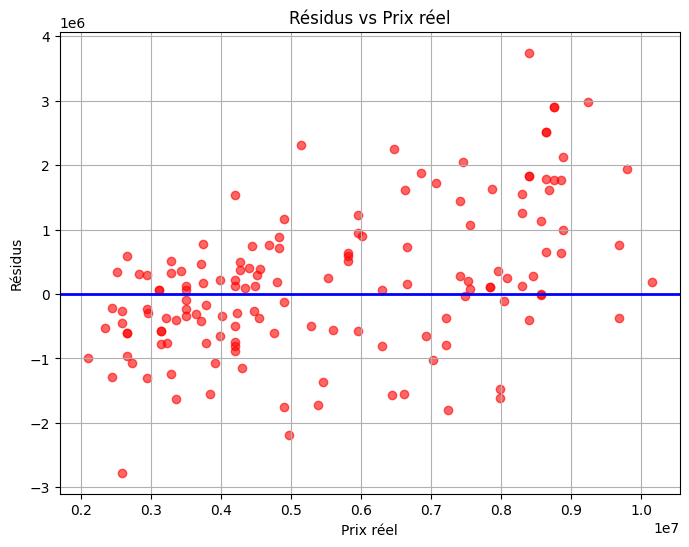

In [129]:
# Visualisation des résidus avec la fonction plot_residuals du fichier figures_plot.py
plot_residuals(y_test, y_pred)

Distribution des résidus autour de zéro : On observe que la majorité des points (résidus) sont proches de la ligne horizontale (y=0), ce qui signifie que pour ces observations, le modèle prédit correctement les prix.

Points au-dessus de la ligne : Ces points indiquent que le modèle a sous-estimé le prix réel (la prédiction est inférieure au prix réel).

Points en dessous de la ligne : Ces points montrent que le modèle a surestimé le prix réel (la prédiction est supérieure au prix réel).

Dispersion des résidus : La dispersion semble s'intensifier pour les prix plus élevés (vers la droite du graphique), indiquant que le modèle a plus de difficulté à prédire les prix pour les maisons les plus chères.

##### Performances du modèle en fonction de la taille du jeu de données:
Les performances du modèle varient considérablement en fonction de la taille du jeu de données. Nous allons tester le modèle avec des jeux de données de tailles différentes afin d’évaluer son comportement et ses performances.

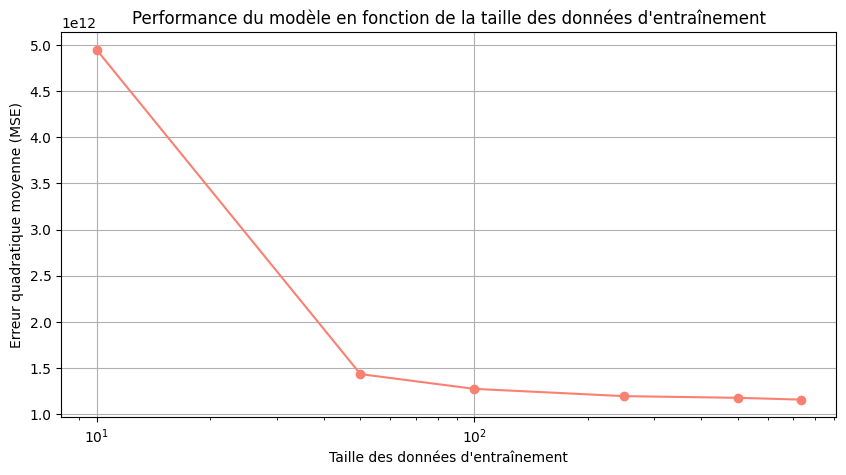

In [130]:
# Initialiser une liste pour stocker les performances
performances = []

# Tailles de données d'entraînement à tester
tailles = [10, 50, 100, 250, 500, len(data)]

# Séparer les variables explicatives et la variable cible pour l'ensemble de test
X_test_reg = data.drop('prix', axis=1)
y_test_reg = data['prix']

# Boucle sur les tailles de données
for taille in tailles:
    # Sélectionner un sous-ensemble aléatoire de la taille spécifiée
    data_train = data.sample(taille, random_state=SEED)

    # Séparer les variables explicatives et la variable cible pour l'entraînement
    X_train_reg = data_train.drop('prix', axis=1)
    y_train_reg = data_train['prix']

    # Initialiser et ajuster le modèle de régression linéaire
    model = LinearRegression()
    model.fit(X_train_reg, y_train_reg)

    # Prédire les prix sur l'ensemble de test
    y_pred = model.predict(X_test_reg)

    # Calculer l'erreur quadratique moyenne
    mse = mean_squared_error(y_test_reg, y_pred)

    # Ajouter la performance à la liste
    performances.append(mse)

# Créer un graphique de la performance en fonction de la taille des données
plt.figure(figsize=(10, 5))
plt.plot(tailles, performances, marker='o', color='salmon')
plt.title("Performance du modèle en fonction de la taille des données d'entraînement")
plt.xlabel("Taille des données d'entraînement")
plt.ylabel("Erreur quadratique moyenne (MSE)")
plt.xscale('log')
plt.grid(True)
plt.show()

# Sauvegarde des performances dans un DataFrame
os.makedirs(os.path.expanduser('~/Desktop/price_prediction/data/reporting'), exist_ok=True)
performances_df = pd.DataFrame({'taille': tailles, 'mse': performances})
performances_df.to_csv(os.path.expanduser('~/Desktop/price_prediction/data/reporting/performances_modele.csv'), index=False)


Le graphique montre que l'erreur quadratique moyenne (MSE) diminue fortement avec l'augmentation de la taille des données d'entraînement, puis se stabilise à partir d'un certain seuil ($10^2$). Cela indique que le modèle nécessite une taille minimale de données pour bien apprendre, mais qu’au-delà, l’ajout de données n’améliore plus significativement les performances.

### Modèle ensembliste:

Dans cette section, nous allons utiliser un des modèles d'ensemble pour effectuer des prédictions. Cette approche est particulièrement utile, car les modèles d'ensemble sont réputés pour leur efficacité dans ce type de problème. Ils présentent notamment des avantages en termes de réduction de la variance, en particulier pour les méthodes parallèles.

Rappel sur les random forest :
 
Les Forêts Aléatoires sont une méthode puissante en apprentissage automatique qui repose sur l'utilisation de plusieurs arbres de décision. Au lieu de s'appuyer sur un seul arbre, cette approche combine les prédictions de plusieurs arbres pour fournir des résultats plus fiables et précis. Chaque arbre est construit à partir d'un échantillon aléatoire des données, permettant ainsi de prendre en compte différentes variations présentes dans le jeu de données. Cette technique s'applique aussi bien aux tâches de classification, où les catégories sont prédites par un vote majoritaire, qu'aux tâches de régression, où les prédictions numériques sont obtenues par une moyenne des résultats. En raison de sa robustesse et de sa précision, les Forêts Aléatoires sont largement utilisées dans des domaines tels que la détection de fraude et le diagnostic médical, où des prédictions fiables sont cruciales.

##### Performances en fonction de max_depth, n_estimators:
Dans cette section, nous analyserons l'impact des hyperparamètres max_depth et n_estimators sur les performances du modèle. Max_depth détermine la profondeur maximale des arbres, tandis que n_estimators contrôle le nombre d'arbres dans le modèle. Nous explorerons comment ces paramètres influencent l'erreur et la capacité de généralisation du modèle.

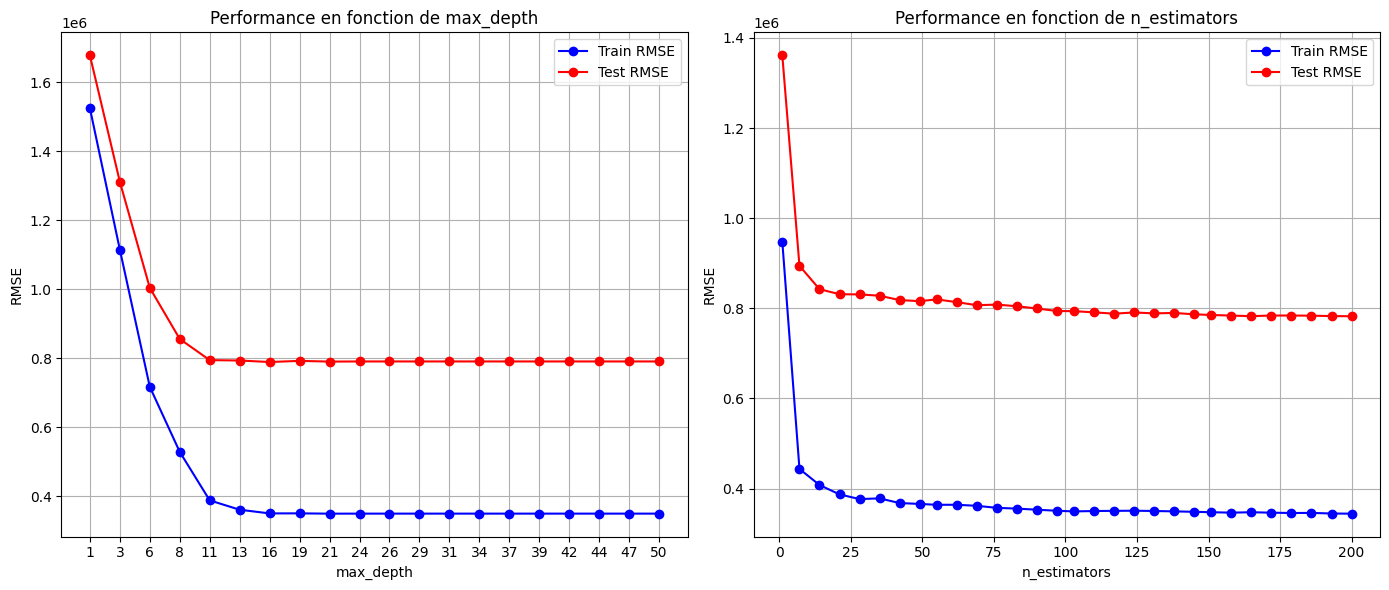

In [131]:
# Définir les valeurs de max_depth et n_estimators à tester
max_depth_values = np.linspace(1, 50, 20, dtype=int) 
n_estimators_values = np.linspace(1, 200, 30, dtype=int)


# Calculer les performances
train_rmse_depth, test_rmse_depth, train_rmse_estimators, test_rmse_estimators = calcul_performance(max_depth_values, n_estimators_values, X_train, y_train, X_test, y_test,SEED)
# Tracer les graphes de performance
plt.figure(figsize=(14, 6))

# Graphique de performance en fonction de max_depth
plt.subplot(1, 2, 1)
# Convertir max_depth_values pour l'affichage et éviter le problème avec None
max_depth_labels = [str(d) if d is not None else 'None' for d in max_depth_values]
plt.plot(max_depth_labels, train_rmse_depth, marker='o', label='Train RMSE', color='blue')
plt.plot(max_depth_labels, test_rmse_depth, marker='o', label='Test RMSE', color='red')
plt.xlabel('max_depth')
plt.ylabel('RMSE')
plt.title('Performance en fonction de max_depth')
plt.legend()
plt.grid(True)

# Graphique de performance en fonction de n_estimators
plt.subplot(1, 2, 2)
plt.plot(n_estimators_values, train_rmse_estimators, marker='o', label='Train RMSE', color='blue')
plt.plot(n_estimators_values, test_rmse_estimators, marker='o', label='Test RMSE', color='red')
plt.xlabel('n_estimators')
plt.ylabel('RMSE')
plt.title('Performance en fonction de n_estimators')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

D'après les figures ci-dessus, on remarque, dans le graphique des performances en fonction de max_depth, que les erreurs sont stables et minimales à partir de max_depth = 16, aussi bien pour les données d'entraînement que pour les données de test.

Concernant le graphique des performances en fonction de n_estimators, on observe que, sur le jeu de données d'entraînement, l'erreur diminue à mesure que le nombre de n_estimators augmente. sur le jeu de données de test : à partir de n_estimators = 100, l'erreur commence à se stabiliser, on pourriat donc choisr comme hypermaramètres. max_depth = 16 et n_estimators = 100.

### Choix des hyperparamètres avec GridSearchCV:


Les résultats de test ci-dessus ont été obtenus sur un jeu de données de test sans validation croisée, ce qui nous donne les hyperparamètres suivants : max_depth = 16 et n_estimators = 100. Ces paramètres ne garantissent pas la généralisabilité du modèle ni qu'ils soient optimaux.

Pour s'assurer d'obtenir les meilleurs paramètres et améliorer les prédictions, il est essentiel d'effectuer une validation croisée. Cela permettra d'identifier les meilleurs hyperparamètres et d'évaluer plus précisément la performance généralisée du modèle sur l'ensemble des données.

Nous utiliserons les fonctions `GridSearchCV` et `RandomizedSearchCV` de Scikit-Learn.

GridSearchCV permet de tester exhaustivement toutes les combinaisons d'hyperparamètres spécifiées.
RandomizedSearchCV effectue une recherche aléatoire dans un espace de paramètres, ce qui peut être plus rapide et plus adapté pour de grands ensembles de données ou un grand nombre d'hyperparamètres.

In [132]:
# Utilisation de la fonction train_and_optimize_rf du fichier models.py pour entraîner et optimiser le modèle
# Cette fonction retourne les résultats de la validation croisée (GridSearchCV)
resultats = train_and_optimize_rf(X_train, y_train, X_test, y_test, SEED)

Optimisation des hyperparamètres en cours...
Optimisation terminée.


In [133]:
# Afficher les meilleurs hyperparamètres trouvés par GridSearchCV
print("Meilleurs hyperparamètres :")
print(resultats['best_params'])

# Afficher le modèle RandomForest optimisé
print("\nModèle RandomForest optimisé :")
print(resultats['best_rf_model'])

# Afficher les métriques d'évaluation
print("\nMétriques d'évaluation :")
print(f"Erreur absolue moyenne (MAE) : {resultats['evaluation_metrics']['MAE']}")
print(f"Erreur quadratique moyenne (RMSE) : {resultats['evaluation_metrics']['RMSE']}")
print(f"Coefficient de détermination (R²) : {resultats['evaluation_metrics']['R2']}")

Meilleurs hyperparamètres :
{'max_depth': 20, 'min_samples_split': 2, 'n_estimators': 100}

Modèle RandomForest optimisé :
RandomForestRegressor(max_depth=20, random_state=25)

Métriques d'évaluation :
Erreur absolue moyenne (MAE) : 586146.3721088434
Erreur quadratique moyenne (RMSE) : 790715.0687772119
Coefficient de détermination (R²) : 0.8707502181516672


Le modèle de forêt aléatoire, optimisé avec GridSearchCV, a donné les meilleurs paramètres suivants : 
une profondeur maximale de 20 (max_depth=20), 100 arbres (n_estimators=100), et un minimum de 2 échantillons pour diviser un nœud (min_samples_split=2). 

Avec ces paramètres, le modèle obtient une bonne performance, expliquant 87 % de la variance de la variable cible (R²), avec une erreur quadratique moyenne (RMSE) de 790,715 et un MAE de 586,146.3, ce qui nous permet d'obtenir de meilleures performances que les modèles précédents. 

### Features importances:

Pour mieux interpréter le modèle de forêt aléatoire, il est essentiel d'identifier les variables qui influencent le plus ses prédictions. En mesurant l'importance de chaque feature, nous obtenons des informations précieuses sur leur contribution au modèle, ce qui peut aider à affiner l'analyse et orienter les choix futurs. Cette section est dédiée à l'extraction et à l'analyse de ces importances pour le modèle optimisé.

In [134]:
# Extraire les importances des features du meilleur modèle
best_rf_model = resultats['best_rf_model']
feature_importances = best_rf_model.feature_importances_

# Associer les importances aux noms des features 
feature_importances_df = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': feature_importances
})

# Trier les features par importance décroissante
feature_importances_df = feature_importances_df.sort_values(by='Importance', ascending=False)

# Afficher les importances
print("Feature Importances:")
print(feature_importances_df)


Feature Importances:
                       Feature  Importance
2               salles_de_bain    0.385677
0                   superficie    0.304063
3                       etages    0.049365
9               places_parking    0.048466
11           statut_meublement    0.039151
8                climatisation    0.034915
7         chauffage_eau_chaude    0.029832
1                     chambres    0.026819
6                     sous_sol    0.026405
10               zone_preferee    0.020476
4   proximite_route_principale    0.019178
5                 chambre_amis    0.015654


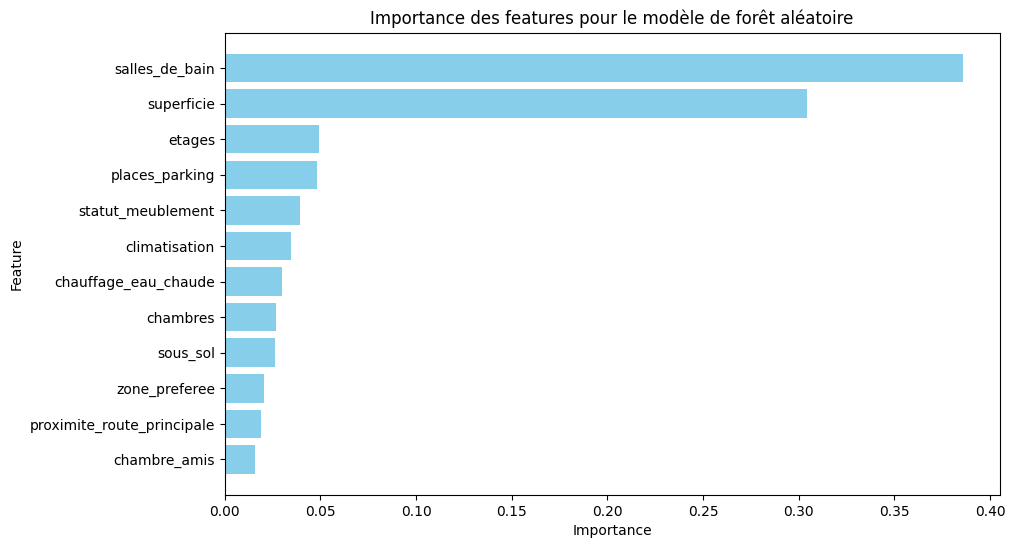

In [135]:
# Tracer les importances des features
plt.figure(figsize=(10, 6))
plt.barh(feature_importances_df['Feature'], feature_importances_df['Importance'], color='skyblue')
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.title("Importance des features pour le modèle de forêt aléatoire")
plt.gca().invert_yaxis()  # Inverser l'axe Y pour afficher les plus importantes en haut
plt.show()

Ce graphique montre que le modèle de forêt aléatoire accorde une importance prédominante aux caractéristiques liées au confort (salles_de_bain) et à la taille (superficie) de la propriété. Les variables comme la climatisation, le nombre de chambres, ou la proximité de la route principale jouent un rôle moindre.

### RandomizedSearchCV 
L'utilisation de RandomizedSearchCV permet d'optimiser efficacement les hyperparamètres du modèle de forêt aléatoire en explorant un sous-ensemble aléatoire des combinaisons possibles, ce qui réduit la charge computationnelle par rapport à une recherche exhaustive. Il permet de trouver la meilleure combinaison de paramètres (comme le nombre d'arbres, la profondeur maximale des arbres, et le nombre minimum d'échantillons pour diviser un nœud) pour améliorer la performance du modèle tout en évitant le surapprentissage et le sous-apprentissage. En intégrant une validation croisée, cette approche garantit une évaluation robuste du modèle. Ainsi, RandomizedSearchCV permet d'obtenir un modèle bien réglé et performant, avec une recherche d'hyperparamètres efficace et une évaluation fiable

In [136]:
# Entrainement du modèle sans les variables qui ont une importance presque nulle
# Sélectionner les features avec une importance supérieure à 0.02
selected_features = feature_importances_df[feature_importances_df['Importance'] > 0.02]['Feature']

# Filtrer les données d'entraînement et de test pour inclure uniquement les features sélectionnées
X_train_selected = X_train[selected_features]
X_test_selected = X_test[selected_features]

In [137]:
# Définir le pipeline avec une étape de standardisation et une de régression
pipeline = Pipeline([
    ('scaler', StandardScaler()),  # Étape de standardisation
    ('rf', RandomForestRegressor(random_state=SEED))  # Modèle Random Forest
])

# Définir la grille de paramètres pour RandomizedSearchCV 
param_dist = {
    'rf__n_estimators': [100, 200],         # Nombre d'arbres dans la forêt
    'rf__max_depth': [10, 20, 30, None],    # Profondeur maximale des arbres
    'rf__min_samples_split': randint(2, 15),  # Nombre minimum d'échantillons pour diviser un nœud
    'rf__min_samples_leaf': randint(1, 5),    # Nombre minimum d'échantillons dans une feuille
    'rf__max_features': ['sqrt', 'log2', None]  # Exclure 'auto'
}

# Configurer RandomizedSearchCV avec 5 sous-ensembles pour la validation croisée
random_search = RandomizedSearchCV(estimator=pipeline, param_distributions=param_dist, n_iter=100, cv=5,
                                   scoring='neg_mean_squared_error', random_state=42, n_jobs=-1)

# Effectuer la recherche sur la meilleure combinaison de paramètres
random_search.fit(X_train_selected, y_train)

# Extraire le modèle avec les meilleurs paramètres
best_rf_model = random_search.best_estimator_

# Prédire les prix sur le jeu de test avec le meilleur modèle trouvé
y_pred = best_rf_model.predict(X_test_selected)

# Calculer les métriques d'évaluation : RMSE et R²
mae = mean_absolute_error(y_test, y_pred)
rmse = root_mean_squared_error(y_test, y_pred)  # Remplacer par mean_squared_error
r2 = r2_score(y_test, y_pred)


In [138]:
print("Best parameters found:", random_search.best_params_)
print(f"Mean Absolute Error (MAE): {mae}")
print(f"Root Mean Squared Error (RMSE): {rmse}")
print(f"R² Score: {r2}")

Best parameters found: {'rf__max_depth': 30, 'rf__max_features': 'log2', 'rf__min_samples_leaf': 1, 'rf__min_samples_split': 2, 'rf__n_estimators': 200}
Mean Absolute Error (MAE): 568062.9177437641
Root Mean Squared Error (RMSE): 757897.6462181029
R² Score: 0.8812562104477666


Les résultats montrent que l'utilisation de RandomizedSearchCV a permis d'optimiser les hyperparamètres du modèle, avec une profondeur d'arbres de 30, 200 arbres. Le RMSE a diminué à 757897, et le R² a augmenté à 0.88, ce qui reflète une performance élevée. Les caractéristiques les plus importantes sont "salles_de_bain" (40,5%) et "superficie" (28,9%). 
Ces améliorations montrent que l'optimisation des paramètres et la sélection des meilleures caractéristiques ont renforcé la précision du modèle.

# 4-Conclusion

Ce projet avait pour objectif de construire un modèle de machine learning capable de prédire le prix des maisons. Nous avons travaillé avec une base de données contenant des variables explicatives telles que la superficie, le nombre de chambres et d'autres caractéristiques influençant les prix.

Pour mener à bien ce projet, nous avons d'abord effectué une analyse exploratoire des données. Cette étape nous a permis de corriger les types de données, de gérer les valeurs manquantes et de visualiser les distributions des variables. Nous avons également découvert des informations clés, notamment une forte corrélation entre la superficie et le prix des maisons.

Dans un second temps, nous avons implémenté des modèles de machine learning. Nous avons commencé par établir une baseline en utilisant le prix moyen par nombre de chambres. Bien que cette approche soit simple, elle a donné des résultats insatisfaisants, ce qui a justifié l'utilisation de modèles plus avancés. Nous avons ensuite construit un modèle de régression linéaire, qui a permis d'améliorer les performances. Enfin, nous avons exploré des modèles d'ensemble, notamment les forêts aléatoires, qui ont donné les meilleurs résultats.

Pour optimiser ces modèles, nous avons utilisé les fonctions GridSearchCV et RandomizedSearchCV de Scikit-learn afin de sélectionner les meilleurs hyperparamètres. Cela a permis d'atteindre des performances optimales. De plus, nous avons testé l'impact de la sélection des meilleures caractéristiques sur les résultats. Cette démarche, combinée avec l'utilisation de RandomizedSearchCV, a conduit à une amélioration notable des performances.

En conclusion, ce projet a démontré l'efficacité des modèles d'ensemble pour prédire le prix des maisons. Il a également mis en évidence l'importance de l’analyse exploratoire des données et de l’optimisation des hyperparamètres dans le cadre d’un projet de machine learning.



Perspectives :
Afin de rendre ce modèle réutilisable et déployable à grande échelle, une prochaine étape consistera à l'enregistrer dans un format compatible avec les systèmes de production, comme un fichier .pkl. Cela permettra de l'intégrer dans une pipeline MLOps (Machine Learning Operations) pour automatiser le déploiement, la surveillance et la mise à jour du modèle en production. 